# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [177]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn import metrics

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [135]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [8]:
azdias_1 = azdias.loc[:100000]
azdias_2 = azdias.loc[100001:200000]
azdias_3 = azdias.loc[200001:300000]
azdias_4 = azdias.loc[300001:400000]
azdias_5 = azdias.loc[400001:500000]
azdias_6 = azdias.loc[500001:600000]
azdias_7 = azdias.loc[600001:700000]
azdias_8 = azdias.loc[700001:800000]
azdias_9 = azdias.loc[800001:]

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**Assessing missing data:**

In [9]:
# Load in the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.drop(['information_level'], axis=1, inplace=True)

In [11]:
missing_or_unknown = []
for value in feat_info['missing_or_unknown']:
    value = str(value)
    list_value = value[1:-1].split(',')
    missing_or_unknown.append(list_value)
feat_info['missing_or_unknown'] = missing_or_unknown

In [12]:
def missing_to_nan(df1, df2):
    for row in df2['attribute']:
        if row in df1.columns:
            na_map = df2.loc[df2['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.nan
        else:
            continue
    return df1

In [13]:
azdias_1 = missing_to_nan(azdias_1, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
azdias_2 = missing_to_nan(azdias_2, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
azdias_3 = missing_to_nan(azdias_3, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
azdias_4 = missing_to_nan(azdias_4, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
azdias_5 = missing_to_nan(azdias_5, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
azdias_6 = missing_to_nan(azdias_6, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
azdias_7 = missing_to_nan(azdias_7, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
azdias_8 = missing_to_nan(azdias_8, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
azdias_9 = missing_to_nan(azdias_9, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
azdias = pd.concat([azdias_1, azdias_2, azdias_3, azdias_4, azdias_5, azdias_6, azdias_7, azdias_8, azdias_9])

**Load of the DIAS Attributes dataset, useful to get the remaining unknown attributes or without transactions:**

In [23]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attributes.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [24]:
dias_attributes.drop(['Unnamed: 0'], axis=1, inplace=True)
dias_attributes = dias_attributes[dias_attributes['Attribute'].isnull() == False]
dias_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [25]:
# We take the attributes that are not already in the feat_info dataframe 
dias_attributes = dias_attributes[dias_attributes['Attribute'].isin(feat_info['attribute']) == False]
dias_attributes.head()

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months


In [26]:
dias_attributes['Meaning'].value_counts()

unknown                                             172
no transaction known                                 34
highest activity within the last 12 months           12
no transactions known                                10
no Online-transactions within the last 12 months      3
Universal                                             1
very low car quote                                    1
Name: Meaning, dtype: int64

**DIAS with unknown meaning or no transactions:**

In [27]:
missing_or_unknown_dias = dias_attributes[dias_attributes['Meaning'].isin(['unknown', 
                                                                           'no transaction known', 
                                                                           'no transactions known'])]
missing_or_unknown_dias = missing_or_unknown_dias[missing_or_unknown_dias['Attribute'].isin(azdias.columns)]
missing_or_unknown_dias.head()

,Attribute,Description,Value,Meaning
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known
478,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known


In [28]:
missing_or_unknown_dias['Value'].value_counts()

-1       106
-1, 9     58
0         10
Name: Value, dtype: int64

In [29]:
azdias[azdias.columns[azdias.columns.isin(missing_or_unknown_dias['Attribute'])]].dtypes.value_counts()

float64    164
int64       10
dtype: int64

In [30]:
missing_or_unknown_dias['type'] = 'ordinal'

In [31]:
# Make a dataframe of features proprieties
missing_or_unknown_dias['missing_or_unknown'] = missing_or_unknown_dias['Value'].apply(lambda x: [x])
missing_or_unknown_dias.drop(['Description', 'Value', 'Meaning'], axis=1, inplace=True)
missing_or_unknown_dias.columns = ['attribute', 'type', 'missing_or_unknown']
missing_or_unknown_dias.head()

,attribute,type,missing_or_unknown
138,D19_BANKEN_ANZ_12,ordinal,[0]
145,D19_BANKEN_ANZ_24,ordinal,[0]
305,D19_GESAMT_ANZ_12,ordinal,[0]
312,D19_GESAMT_ANZ_24,ordinal,[0]
478,D19_TELKO_ANZ_12,ordinal,[0]


In [32]:
missing_or_unknown = []
for value in missing_or_unknown_dias['missing_or_unknown']:
    value = str(value)
    list_value = value[1:-1].split(',')
    missing_or_unknown.append(list_value)
missing_or_unknown_dias['missing_or_unknown'] = missing_or_unknown

In [33]:
azdias_1 = missing_to_nan(azdias_1, missing_or_unknown_dias)

In [34]:
azdias_2 = missing_to_nan(azdias_2, missing_or_unknown_dias)

In [35]:
azdias_3 = missing_to_nan(azdias_3, missing_or_unknown_dias)

In [36]:
azdias_4 = missing_to_nan(azdias_4, missing_or_unknown_dias)

In [37]:
azdias_5 = missing_to_nan(azdias_5, missing_or_unknown_dias)

In [38]:
azdias_6 = missing_to_nan(azdias_6, missing_or_unknown_dias)

In [39]:
azdias_7 = missing_to_nan(azdias_7, missing_or_unknown_dias)

In [40]:
azdias_8 = missing_to_nan(azdias_8, missing_or_unknown_dias)

In [41]:
azdias_9 = missing_to_nan(azdias_9, missing_or_unknown_dias)

In [42]:
azdias = pd.concat([azdias_1, azdias_2, azdias_3, azdias_4, azdias_5, azdias_6, azdias_7, azdias_8, azdias_9])

**Complete feat_info with the remaining variables (which do not have missing or unknown values):**

In [43]:
# Investigate the rest of attributes 
remaining_dias = dias_attributes[dias_attributes['Meaning'].isin(['unknown',
                                                                  'no transaction known',
                                                                  'no transactions known']) == False]
remaining_dias = remaining_dias[remaining_dias['Attribute'].isin(azdias.columns)]
remaining_dias.head()

,Attribute,Description,Value,Meaning
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
186,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
196,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
206,D19_BANKEN_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months
319,D19_GESAMT_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months


In [44]:
azdias[azdias.columns[azdias.columns.isin(remaining_dias['Attribute'])]].dtypes.value_counts()

int64      12
float64     5
dtype: int64

In [45]:
remaining_dias['type'] = 'ordinal'

In [46]:
remaining_dias['missing_or_unknown'] = remaining_dias['Value'].apply(lambda x: list())
remaining_dias.drop(['Description', 'Value', 'Meaning'], axis=1, inplace=True)
remaining_dias.columns = ['attribute', 'type', 'missing_or_unknown']
remaining_dias.head()

,attribute,type,missing_or_unknown
152,D19_BANKEN_DATUM,ordinal,[]
186,D19_BANKEN_OFFLINE_DATUM,ordinal,[]
196,D19_BANKEN_ONLINE_DATUM,ordinal,[]
206,D19_BANKEN_ONLINE_QUOTE_12,ordinal,[]
319,D19_GESAMT_DATUM,ordinal,[]


In [47]:
new_feat_info = pd.concat([feat_info, missing_or_unknown_dias, remaining_dias])

In [48]:
# azdias columns that are not in the df of feat info
remaining_cols = azdias.columns[azdias.columns.isin(new_feat_info['attribute']) == False]

In [49]:
azdias[remaining_cols].dtypes.value_counts()

float64    49
int64      39
object      2
dtype: int64

In [50]:
categoric_cols = azdias[remaining_cols].select_dtypes(include='object').columns.tolist()

In [51]:
numeric_cols = azdias[remaining_cols].select_dtypes(exclude='object').columns.tolist()

In [52]:
remaining_attrib = pd.DataFrame({'attribute': remaining_cols})

In [53]:
len(categoric_cols)

2

In [54]:
len(numeric_cols)

88

In [55]:
types = []
for attribute in remaining_attrib['attribute']:
    if attribute in numeric_cols:
        att_type = 'numeric'
    elif attribute in categoric_cols:
        att_type = 'categorical'
    types.append(att_type)
    
remaining_attrib['type'] = types

In [56]:
remaining_attrib['type'].value_counts()

numeric        88
categorical     2
Name: type, dtype: int64

In [57]:
remaining_attrib['missing_or_unknown'] = remaining_attrib['type'].apply(lambda x: list())
remaining_attrib.head()

,attribute,type,missing_or_unknown
0,LNR,numeric,[]
1,AKT_DAT_KL,numeric,[]
2,ALTER_KIND1,numeric,[]
3,ALTER_KIND2,numeric,[]
4,ALTER_KIND3,numeric,[]


In [58]:
# Concat feat info
new_feat_info = pd.concat([new_feat_info, remaining_attrib], ignore_index=True)
print(new_feat_info.shape)
new_feat_info.head()

(366, 3)


,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [61]:
azdias = pd.read_csv('azdias.csv')

In [4]:
new_feat_info = pd.read_csv('new_feat_info.csv')

**Create copy of main dfs:** 

We'll work with those now in order to keep the new_feat_info dataset original for later use. 

In [63]:
copy_azdias = azdias.copy()
copy_feat_info = new_feat_info.copy()

**Convert missing data to NaN:**

In [64]:
def is_int(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

In [65]:
copy_feat_info['missing_or_unknown'] = copy_feat_info.apply(lambda x: [int(i) if is_int(i) else i for i in x['missing_or_unknown']], axis=1)

In [66]:
for idx in copy_feat_info.index:
    column = idx
    if column in copy_azdias.columns:
        copy_azdias[column] = copy_azdias[column].replace(copy_feat_info.loc[column]['missing_or_unknown'], np.nan)

**Assess missing data in each column:**

Text(0,0.5,'NaN values')

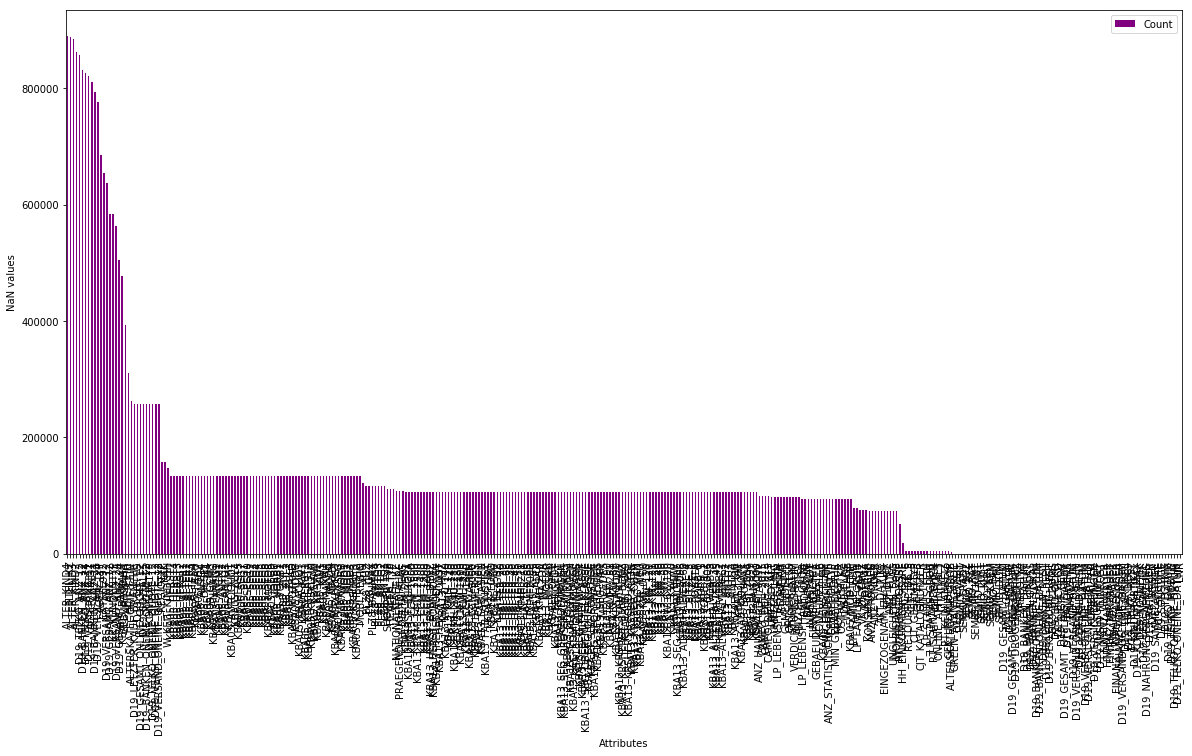

In [67]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

count_list = []
nan_list = []
for column in copy_azdias.columns:
    nan_count = copy_azdias[column].isnull().sum()
    count_list.append(nan_count)
    nan_list.append((column, nan_count))

nan_data = pd.DataFrame(nan_list, columns=['Column', 'Count'])
nan_data.sort_values('Count', inplace=True, ascending=False)

# We are creating a new dataframe with the name of the columns as index so that we can display them in the graph
# The purpose is merely visual, in the rest of the project we will work with nan_data
nan_dict = {'Count': count_list}
nan_df = pd.DataFrame(data=nan_dict, index = copy_azdias.columns)
nan_df.sort_values('Count', inplace=True, ascending=False)

nan_df.plot.bar(color='Purple', figsize=(20, 10));
plt.xlabel('Attributes')
plt.ylabel('NaN values')

In [68]:
# Investigate patterns in the amount of missing data in each column.
nan_group = []
nan_prop = []
nan_percent = []
dropping = []

print("From the graph, we set a threshold of 30% for the variables to drop.")
print("Thus, we will be dropping:")

for i, count in enumerate(nan_data['Count']):
    col = nan_data['Column'].iloc[i]
    x_nan = count / len(copy_azdias)
    perc_nan = round(x_nan * 100, 2)

    nan_prop.append(x_nan)
    nan_percent.append(x_nan * 100)

    if x_nan == 0:
        nan_group.append(1)
    elif x_nan > 0 and x_nan <= 0.05:
        nan_group.append(2)
    elif x_nan > 0.05 and x_nan <= 0.1:
        nan_group.append(3)
    elif x_nan > 0.1 and x_nan <= 0.15:
        nan_group.append(4)
    elif x_nan > 0.15 and x_nan <= 0.2:
        nan_group.append(5)
    elif x_nan > 0.2 and x_nan <= 0.25:
        nan_group.append(6)
    elif x_nan > 0.25 and x_nan <= 0.3:
        nan_group.append(7)
    else:
        print("{}, {}% of NaN values".format(col, perc_nan))
        dropping.append(col)
        
nan_data['Proportion'] = nan_prop
nan_data['Percentage'] = nan_percent

From the graph, we set a threshold of 30% for the variables to drop.
Thus, we will be dropping:
ALTER_KIND4, 99.86% of NaN values
TITEL_KZ, 99.76% of NaN values
ALTER_KIND3, 99.31% of NaN values
ALTER_KIND2, 96.69% of NaN values
D19_TELKO_ANZ_12, 96.27% of NaN values
D19_BANKEN_ANZ_12, 93.33% of NaN values
D19_TELKO_ANZ_24, 92.71% of NaN values
D19_VERSI_ANZ_12, 92.15% of NaN values
ALTER_KIND1, 90.9% of NaN values
D19_BANKEN_ANZ_24, 89.1% of NaN values
D19_VERSI_ANZ_24, 87.19% of NaN values
AGER_TYP, 76.96% of NaN values
EXTSEL992, 73.4% of NaN values
D19_VERSAND_ANZ_12, 71.58% of NaN values
D19_GESAMT_ANZ_12, 65.62% of NaN values
KK_KUNDENTYP, 65.6% of NaN values
D19_VERSAND_ANZ_24, 63.26% of NaN values
D19_GESAMT_ANZ_24, 56.7% of NaN values
KBA05_BAUMAX, 53.47% of NaN values
GEBURTSJAHR, 44.02% of NaN values
ALTER_HH, 34.81% of NaN values


In [69]:
dropping

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'D19_TELKO_ANZ_12',
 'D19_BANKEN_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSI_ANZ_12',
 'ALTER_KIND1',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ANZ_24',
 'AGER_TYP',
 'EXTSEL992',
 'D19_VERSAND_ANZ_12',
 'D19_GESAMT_ANZ_12',
 'KK_KUNDENTYP',
 'D19_VERSAND_ANZ_24',
 'D19_GESAMT_ANZ_24',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [70]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(dropping, axis=1)

In [71]:
print("Let's get some insights!")
print("No missing values:")
print("{} attributes without missing or unknown values.".format(nan_group.count(1)))
print("Missing values with less than 20% of missing values:")
print("{} with a proportion lower or equal to 5%, {} with a proportion between 10% and 15% and {} between 15% and 20%.".format(nan_group.count(2), nan_group.count(3), nan_group.count(4)))
print("Missing values with a proportion higher than 20% but lower than our threshold, 30%:")
print("Finaly, there are {} between 20% and 25%, and {} between 25% and 30%.".format(nan_group.count(5), nan_group.count(6)))

Let's get some insights!
No missing values:
75 attributes without missing or unknown values.
Missing values with less than 20% of missing values:
17 with a proportion lower or equal to 5%, 16 with a proportion between 10% and 15% and 224 between 15% and 20%.
Missing values with a proportion higher than 20% but lower than our threshold, 30%:
Finaly, there are 3 between 20% and 25%, and 0 between 25% and 30%.


In [72]:
# Remove from feat_info the rows correspondent to the variables that were deleted from azdias 
# This is necessary to keep consistency between both datasets
for variable in dropping:
    copy_feat_info = copy_feat_info[copy_feat_info.attribute != variable]

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 21 columns that standout considerably because of their amount of missing values. These are: ALTER_KIND4, TITEL_KZ, ALTER_KIND3, ALTER_KIND2, D19_TELKO_ANZ_12, D19_BANKEN_ANZ_12, D19_TELKO_ANZ_24, D19_VERSI_ANZ_12, ALTER_KIND1, D19_BANKEN_ANZ_24, D19_VERSI_ANZ_24, AGER_TYP, EXTSEL992, D19_VERSAND_ANZ_12, D19_GESAMT_ANZ_12, KK_KUNDENTYP, D19_VERSAND_ANZ_24, D19_GESAMT_ANZ_24, KBA05_BAUMAX, GEBURTSJAHR and ALTER_HH. All of them have more than 30% of their values missing, which was the threshold used to decide which columns to drop. It is relevant noting that there are similarities in the amounts of missing or unknown values for different groups of the attributes. We can see above that there is a considerable number of variables without any missing value, and then most of the rest fall between 0 and 20%, with special emphasis in the interval 15-20%.

**Assess missing data by rows:**

In [73]:
# Amount of data missing in each row of the azdias dataset
missing_values_by_row = copy_azdias.isnull().sum(axis=1)
missing_values_by_row.head()

0    269
1     28
2     18
3     24
4      9
dtype: int64

In [74]:
# Getting some information
missing_values_by_row.describe()

count    891221.000000
mean         49.561514
std          77.406933
min           2.000000
25%          14.000000
50%          19.000000
75%          30.000000
max         275.000000
dtype: float64

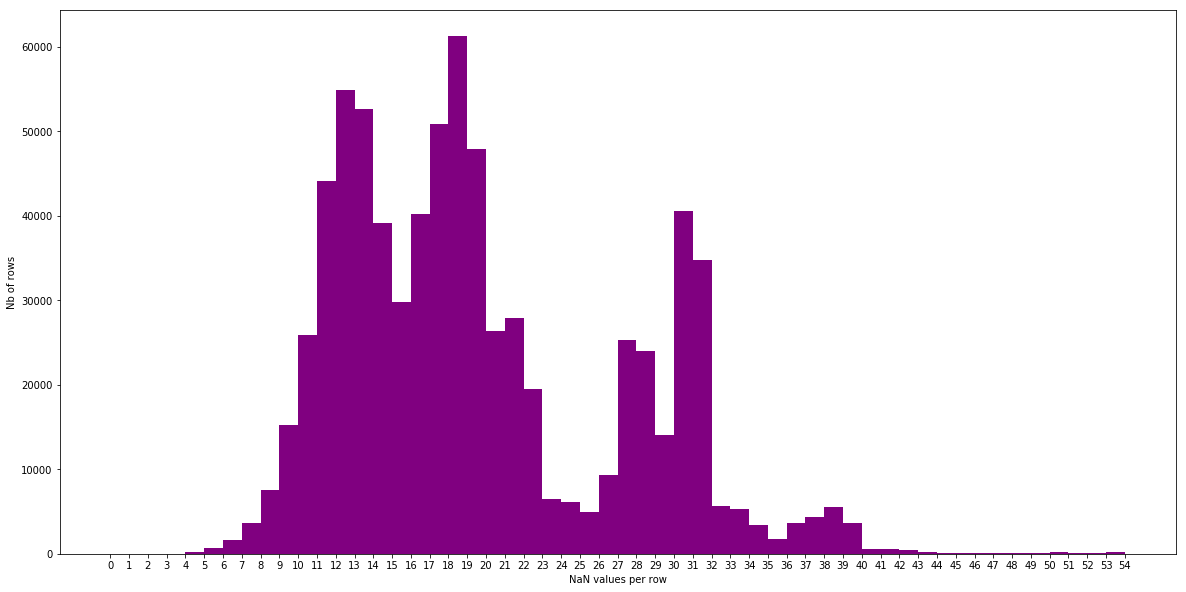

In [75]:
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(0, 55, 1))
plt.xlabel('NaN values per row')
plt.ylabel('Nb of rows')
plt.hist(missing_values_by_row, color='purple', bins=np.arange(0, 55, 1));

In [76]:
rows = len(copy_azdias)
rows_with_missing_values = missing_values_by_row[missing_values_by_row != 0].count()
rows_without_missing_values = missing_values_by_row[missing_values_by_row == 0].count()

percent_missing = rows_with_missing_values / rows * 100
percent_no_missing = 100 - percent_missing

In [77]:
print("Number of rows without any missing values:")
print("{}, {}% of total number of rows".format(rows_without_missing_values, round(percent_no_missing, 2)))

Number of rows without any missing values:
0, 0.0% of total number of rows


In [78]:
missing_values_by_row.describe()

count    891221.000000
mean         49.561514
std          77.406933
min           2.000000
25%          14.000000
50%          19.000000
75%          30.000000
max         275.000000
dtype: float64

In [79]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# With describe() we could see that the mean value of missing values by row is 49.56
# Thus, the threshold will be set as 50

# Reminder: missing_values_by_row = azdias.isnull().sum(axis=1)

threshold = 50
azdias_c_low = copy_azdias[missing_values_by_row < threshold].reset_index(drop=True)
azdias_c_high = copy_azdias[missing_values_by_row >= threshold].reset_index(drop=True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

When assessing the missing data by rows the thereshold was set as 50 missing values by row since the mean of missing values was 49.56. Thus, our final dataset is one where all rows have less than 50 missing values. 

It can be concluded from the analysis that many of the variables present a different distribrution between the rows with many missing values and those with just a few, which means that data is qualitatively different between them. 

In [68]:
azdias_c_low = pd.read_csv('azdias_c_low.csv')

In [69]:
copy_feat_info = pd.read_csv('copy_feat_info.csv')

**Re-encode categorical features:**

In [81]:
copy_feat_info.type.value_counts(dropna=False)

ordinal        230
numeric         89
categorical     20
mixed            6
Name: type, dtype: int64

In [82]:
categ_var = copy_feat_info[copy_feat_info.type == 'categorical'].attribute.tolist()

In [83]:
azdias_c_low[categ_var].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,2.0,5.0,1.0,10.0,0.0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8.0,8A,NaN,1992-02-10 00:00:00
1,2.0,3.0,1.0,10.0,1.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4.0,4C,D19_UNBEKANNT,1992-02-12 00:00:00
2,2.0,2.0,6.0,1.0,0.0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2.0,2A,D19_UNBEKANNT,1997-04-21 00:00:00
3,1.0,5.0,5.0,5.0,0.0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6.0,6B,D19_SCHUHE,1992-02-12 00:00:00
4,2.0,2.0,2.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8.0,8C,D19_ENERGIE,1992-02-12 00:00:00


In [84]:
binary_num_var = []
binary_str_var = []
multi_level_var = []

for variable in categ_var:
    if len(azdias_c_low[variable].value_counts()) > 2:
        multi_level_var.append(variable)
    else:
        if azdias_c_low[variable].dtype == 'object':
            binary_str_var.append(variable)
        else:
            binary_num_var.append(variable)

In [85]:
binary_str_var

['OST_WEST_KZ']

In [86]:
azdias_c_low[binary_str_var].dtypes

OST_WEST_KZ    object
dtype: object

In [87]:
azdias_c_low[binary_str_var].head()

,OST_WEST_KZ
0,W
1,W
2,W
3,W
4,W


In [88]:
# Re-encode OST_WEST_KZ as dummy variable
azdias_c_low['OST_WEST_KZ'] = azdias_c_low['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [89]:
binary_num_var

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [90]:
azdias_c_low[binary_num_var].dtypes

ANREDE_KZ           float64
GREEN_AVANTGARDE    float64
SOHO_KZ             float64
VERS_TYP            float64
dtype: object

In [91]:
multi_level_var

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM']

In [92]:
azdias_c_low.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)

In [93]:
copy_feat_info = copy_feat_info[copy_feat_info.attribute != 'D19_LETZTER_KAUF_BRANCHE']
copy_feat_info = copy_feat_info[copy_feat_info.attribute != 'EINGEFUEGT_AM']

In [94]:
multi_level_var = multi_level_var[:-2]
multi_level_var

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [95]:
# Convert categorical variables to dummies 
def encode_cat_dummies(df, variables_list):
    for variable in variables_list:
        dummies_df = pd.get_dummies(df[variable], prefix=variable)
        df.drop(variable, axis=1, inplace=True)
        df = pd.concat([df, dummies_df], axis=1)
    return df

In [96]:
new_azdias = encode_cat_dummies(azdias_c_low, multi_level_var)

In [97]:
# Engineer Mixed-Type Features
mixed_var = copy_feat_info.attribute[copy_feat_info.type == 'mixed'].tolist()
mixed_var

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [98]:
life_stage = {1: 'younger_age',    2: 'middle_age',      3: 'younger_age',     4: 'middle_age',    5: 'advanced_age', 
              6: 'retirement_age', 7: 'advanced_age',    8: 'retirement_age',  9: 'middle_age',   10: 'middle_age', 
             11: 'advanced_age',  12: 'retirement_age', 13: 'advanced_age',   14: 'younger_age',  15: 'advanced_age',
             16: 'advanced_age',  17: 'middle_age',     18: 'younger_age',    19: 'advanced_age', 20: 'advanced_age', 
             21: 'middle_age',    22: 'middle_age',     23: 'middle_age',     24: 'middle_age',   25: 'middle_age', 
             26: 'middle_age',    27: 'middle_age',     28: 'middle_age',     29: 'younger_age',  30: 'younger_age',
             31: 'advanced_age',  32: 'advanced_age',   33: 'younger_age',    34: 'younger_age',  35: 'younger_age', 
             36: 'advanced_age',  37: 'advanced_age',   38: 'retirement_age', 39: 'middle_age',   40: 'retirement_age'}

fine_scale = {1: 'low',       2: 'low',      3: 'average',  4: 'average',   5: 'low',      6: 'low',      7: 'average',   
              8: 'average',   9: 'average', 10: 'wealthy', 11: 'average',  12: 'average', 13: 'top',     14: 'average', 
             15: 'low',      16: 'average', 17: 'average', 18: 'wealthy',  19: 'wealthy', 20: 'top',     21: 'low',
             22: 'average',  23: 'wealthy', 24: 'low',     25: 'average',  26: 'average', 27: 'average', 28: 'top',     
             29: 'low',      30: 'average', 31: 'low',     32: 'average',  33: 'average', 34: 'average', 35: 'top', 
             36: 'average',  37: 'average', 38: 'average', 39: 'top',      40: 'top'}

new_azdias['LP_life_stage'] = new_azdias['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_azdias['LP_fine_scale'] = new_azdias['LP_LEBENSPHASE_FEIN'].map(fine_scale)

# Drop LP_LEBENSPHASE_FEIN
new_azdias.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [99]:
# R-encode LP_life_stage and LP_fine_scale as ordinal
dic_life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3, 'retirement_age': 4}
dic_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

new_azdias['LP_life_stage'] = new_azdias['LP_life_stage'].map(dic_life)
new_azdias['LP_fine_scale'] = new_azdias['LP_fine_scale'].map(dic_scale)

new_azdias.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

In [100]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

new_azdias['PRAEGENDE_JUGENDJAHRE'].describe()

decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90, 
          np.nan: np.nan, -1: np.nan, 0: np.nan}
avantgarde = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1,
              np.nan: np.nan, -1: np.nan, 0: np.nan}

new_azdias['YOUTH'] = new_azdias['PRAEGENDE_JUGENDJAHRE'].map(decade)
new_azdias['AVANTGARDE'] = new_azdias['PRAEGENDE_JUGENDJAHRE'].map(avantgarde)

new_azdias = new_azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [101]:
# replace 0 by nan
new_azdias['WOHNLAGE'] = new_azdias['WOHNLAGE'].replace(0, np.nan)

In [102]:
dummies_list = ['WOHNLAGE', 'PLZ8_BAUMAX']
new_azdias = encode_cat_dummies(new_azdias, dummies_list)

In [103]:
def encode_CAMEO_INTL_2015(value):
    if np.isnan(value):
        return [np.nan, np.nan]
    else:
        value = str(value).split('.')[0]
        return [int(value[0]), int(value[1])]


new_azdias["CAMEO_INTL_2015"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: float(x))
new_azdias["CAMEO_INTL_2015"] = new_azdias["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

# CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE
new_azdias["CAMEO_INTL_2015_WEALTH"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: x[0])
new_azdias["CAMEO_INTL_2015_LIFE_STAGE"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
new_azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

**Cleaning function:**

In [120]:
def is_int(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

In [121]:
def encode_cat_dummies(df, variables_list):
    for variable in variables_list:
        dummies_df = pd.get_dummies(df[variable], prefix=variable)
        df.drop(variable, axis=1, inplace=True)
        df = pd.concat([df, dummies_df], axis=1)
    return df

In [122]:
def encode_CAMEO_INTL_2015(value):
    if np.isnan(value):
        return [np.nan, np.nan]
    else:
        value = str(value).split('.')[0]
        return [int(value[0]), int(value[1])]

In [123]:
dropping = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_BANKEN_ANZ_12',
            'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24',
            'AGER_TYP', 'EXTSEL992', 'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24',
            'D19_GESAMT_ANZ_24', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

categ_var = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
             'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ',
             'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
             'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

binary_str_var = ['OST_WEST_KZ']

binary_num_var = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

multi_level_var = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                   'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ','SHOPPER_TYP', 'ZABEOTYP', 
                   'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

mixed_var = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 
             'PLZ8_BAUMAX']

life_stage = {1: 'younger_age',    2: 'middle_age',      3: 'younger_age',     4: 'middle_age',    5: 'advanced_age', 
              6: 'retirement_age', 7: 'advanced_age',    8: 'retirement_age',  9: 'middle_age',   10: 'middle_age', 
              11: 'advanced_age', 12: 'retirement_age', 13: 'advanced_age',   14: 'younger_age',  15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age',     18: 'younger_age',    19: 'advanced_age', 20: 'advanced_age', 
              21: 'middle_age',   22: 'middle_age',     23: 'middle_age',     24: 'middle_age',   25: 'middle_age', 
              26: 'middle_age',   27: 'middle_age',     28: 'middle_age',     29: 'younger_age',  30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age',   33: 'younger_age',    34: 'younger_age',  35: 'younger_age', 
              36: 'advanced_age', 37: 'advanced_age',   38: 'retirement_age', 39: 'middle_age',   40: 'retirement_age'}

fine_scale = {1: 'low',       2: 'low',      3: 'average',  4: 'average',   5: 'low',      6: 'low',      7: 'average',   
              8: 'average',   9: 'average', 10: 'wealthy', 11: 'average',  12: 'average', 13: 'top',     14: 'average', 
              15: 'low',     16: 'average', 17: 'average', 18: 'wealthy',  19: 'wealthy', 20: 'top',     21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low',     25: 'average',  26: 'average', 27: 'average', 28: 'top',     
              29: 'low',     30: 'average', 31: 'low',     32: 'average',  33: 'average', 34: 'average', 35: 'top', 
              36: 'average', 37: 'average', 38: 'average', 39: 'top',      40: 'top'}

dic_life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3, 'retirement_age': 4}
dic_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90, 
          np.nan: np.nan, -1: np.nan, 0: np.nan}
avantgarde = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1,
              np.nan: np.nan, -1: np.nan, 0: np.nan}

dummies_list = ['WOHNLAGE', 'PLZ8_BAUMAX']

In [124]:
def clean_data(df):
    
    df_c = df.copy()
    feat_info_c = new_feat_info.copy()
    
    feat_info_c['missing_or_unknown'] = feat_info_c.apply(lambda x: [int(i) if is_int(i) 
                                                                     else i for i in x['missing_or_unknown']], axis=1)
    
    for idx in feat_info_c.index:
        column = idx
        if column in df_c.columns:
            df_c[column] = df_c[column].replace(feat_info_c.loc[column]['missing_or_unknown'], np.nan)
            
    df_c = df_c.drop(dropping, axis=1)
    
    for variable in dropping:
        feat_info_c = feat_info_c[feat_info_c.attribute != variable]
    
    missing_values_by_row = df_c.isnull().sum(axis=1)
    
    threshold = 50
    df_c = df_c[missing_values_by_row < threshold].reset_index(drop=True)
    
    df_c['OST_WEST_KZ'] = df_c['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    df_c = encode_cat_dummies(df_c, multi_level_var)
    
    df_c['LP_life_stage'] = df_c['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df_c['LP_fine_scale'] = df_c['LP_LEBENSPHASE_FEIN'].map(fine_scale)
    df_c.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    df_c['LP_life_stage'] = df_c['LP_life_stage'].map(dic_life)
    df_c['LP_fine_scale'] = df_c['LP_fine_scale'].map(dic_scale)
    df_c.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    df_c['YOUTH'] = df_c['PRAEGENDE_JUGENDJAHRE'].map(decade)
    df_c['AVANTGARDE'] = df_c['PRAEGENDE_JUGENDJAHRE'].map(avantgarde)

    df_c = df_c.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    df_c['WOHNLAGE'] = df_c['WOHNLAGE'].replace(0, np.nan)
    
    df_c = encode_cat_dummies(df_c, dummies_list)
    
    df_c["CAMEO_INTL_2015"] = df_c["CAMEO_INTL_2015"].replace('XX', np.nan)
    df_c["CAMEO_INTL_2015"] = df_c["CAMEO_INTL_2015"].apply(lambda x: float(x))
    df_c["CAMEO_INTL_2015"] = df_c["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

    df_c["CAMEO_INTL_2015_WEALTH"] = df_c["CAMEO_INTL_2015"].apply(lambda x: x[0])
    df_c["CAMEO_INTL_2015_LIFE_STAGE"] = df_c["CAMEO_INTL_2015"].apply(lambda x: x[1])
    df_c.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    return df_c

In [ ]:
azdias_clean = clean_data(azdias)

**Feature Scaling:**

In [108]:
# Initialize the imputer and scaler
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
scaler = MinMaxScaler()

In [110]:
azdias_imputed = pd.DataFrame(imputer.fit_transform(new_azdias), columns=new_azdias.columns)
azdias_ss = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)

In [114]:
azdias_ss = pd.read_csv('azdias_ss.csv')

### Discussion 2.1: Apply Feature Scaling

In order to replace NaN values (needed for the unsupervised method to work properly) I decided to use Imputer and substitute them with the mean value of the variable, since I thought it was the simplest way and the mean a good measure to apply to the data for the prediction. Then, data was scaled to obtain a minimum value of 0 and maximum of 1.

**Dimensionality Reduction:**

In [114]:
# Apply PCA to the data.
pca = PCA()
pca_fit = pca.fit(azdias_ss)

In [115]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca): # Function from PCA lesson
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    RETURN: None
    '''
    num_components= len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cumvals)
    for i in range(num_components):
        if(i%20 == 0 or i<6):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

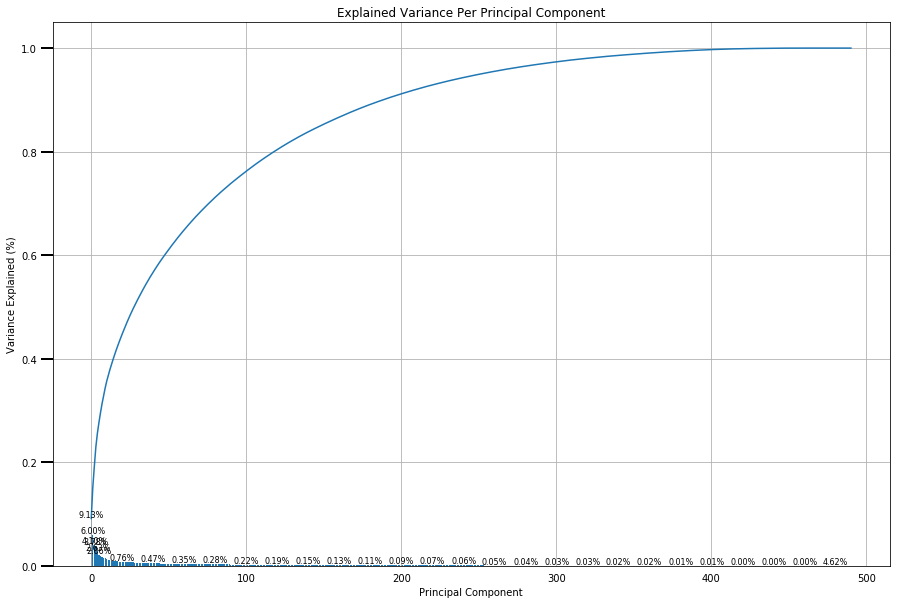

In [116]:
scree_plot(pca_fit)

### Discussion 2.2: Perform Dimensionality Reduction

I chose to retain 200 components since it provides more than 90% of variance, which is a pretty high value. It is interesting mentioning that just around 5 principal components would provide about 20% of variance, and retaining just 20 would provide almost 50%. However, 200 were chosen since we are looking to keep the highest variance possible in order not to lose much precision in the results.  

In [115]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias_ss)

In [116]:
# CLUSTER
centers = []
scores = []

# Over a number of different cluster counts...
for cluster in range(2, 15, 1):
    # run k-means clustering on the data and...
    kmean = KMeans(cluster)
    model = kmean.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    centers.append(cluster)
    scores.append(np.abs(model.score(azdias_pca)))    

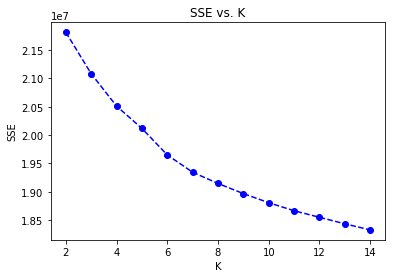

In [117]:
# Investigate the change in within-cluster distance across number of clusters

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [118]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(7).fit(azdias_pca)
azdias_pred = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

It was considered that 7 clusters will be enough for the prediction, being there where the slope changes a little bit closer to the horizontal axis in the graph. 

**Customers:**

In [136]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

In [137]:
customers_clean.select_dtypes(include='object').head()

,PRODUCT_GROUP,CUSTOMER_GROUP
0,COSMETIC_AND_FOOD,MULTI_BUYER
1,COSMETIC_AND_FOOD,MULTI_BUYER
2,COSMETIC,MULTI_BUYER
3,FOOD,MULTI_BUYER
4,COSMETIC_AND_FOOD,MULTI_BUYER


In [138]:
customers_clean['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    72960
FOOD                 32283
COSMETIC             29901
Name: PRODUCT_GROUP, dtype: int64

In [139]:
customers_clean['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     95227
SINGLE_BUYER    39917
Name: CUSTOMER_GROUP, dtype: int64

In [140]:
dummies = ['PRODUCT_GROUP', 'CUSTOMER_GROUP']
customers_clean = encode_cat_dummies(customers_clean, dummies)

In [141]:
customers_clean = customers_clean.replace(np.nan, 0)

In [144]:
customers_clean.drop('LNR', axis=1, inplace=True)

In [148]:
customers_imputed = pd.DataFrame(imputer.fit_transform(customers_clean), columns=customers_clean.columns)
customers_ss = pd.DataFrame(scaler.fit_transform(customers_imputed), columns=customers_imputed.columns)

In [149]:
# Re-apply PCA to the data while selecting for number of components to retain.
customers_pca = pca.fit_transform(customers_ss)

In [150]:
customers_pred = kmeans.predict(customers_pca)

**Comparison:**

In [151]:
counts_cluster_gen = pd.Series(azdias_pred).value_counts().sort_index()
counts_cluster_gen.index = [1,2,3,4,5,6,7]

prop_cluster_gen = []
for value in counts_cluster_gen:
    prop = value / len(azdias_pred)
    prop_cluster_gen.append(prop)

prop_cluster_general = pd.Series(prop_cluster_gen)
prop_cluster_general.index = [1,2,3,4,5,6,7]

In [152]:
counts_cluster_cust = pd.Series(customers_pred).value_counts().sort_index()
counts_cluster_cust.index = [1,2,3,4,5,6,7]

prop_cluster_cust = []
for value in counts_cluster_cust:
    prop = value / len(customers_pred)
    prop_cluster_cust.append(prop)

prop_cluster_customers = pd.Series(prop_cluster_cust)
prop_cluster_customers.index = [1,2,3,4,5,6,7]

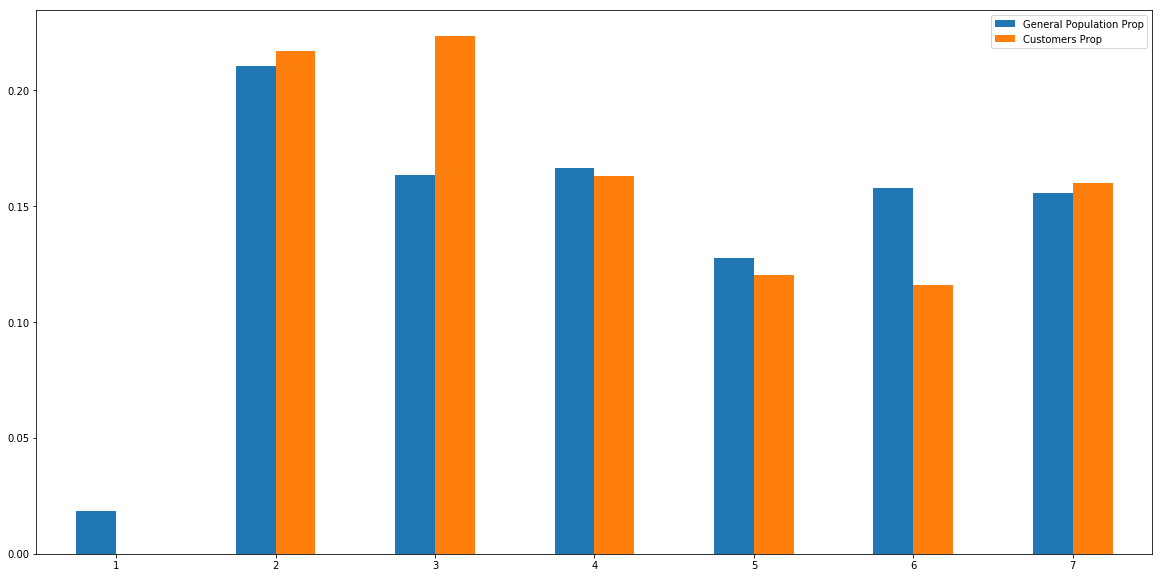

In [153]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

prop = pd.DataFrame({'General Population Prop': prop_cluster_general,
                     'Customers Prop': prop_cluster_customers})
ax = prop.plot.bar(rot=0, figsize=(20, 10))

In [156]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_pred==3)])).round()
df_under = pd.DataFrame(data=over, columns=customers_clean.columns)
df_under.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER
0,1.0,9.0,-3.0,-0.0,0.0,2.0,-4.0,0.0,2.0,6.0,...,0.0,-0.0,0.0,2.0,3.0,-0.0,1.0,0.0,1.0,0.0
1,1.0,16.0,-1.0,-0.0,0.0,3.0,-2.0,-0.0,3.0,2.0,...,0.0,-0.0,0.0,1.0,5.0,1.0,0.0,-0.0,1.0,0.0
2,2.0,11.0,1.0,0.0,-0.0,1.0,1.0,0.0,2.0,6.0,...,0.0,-0.0,-0.0,1.0,4.0,0.0,-0.0,1.0,-0.0,1.0
3,5.0,12.0,-0.0,-0.0,0.0,3.0,-0.0,-0.0,3.0,2.0,...,0.0,-0.0,0.0,1.0,5.0,-0.0,1.0,0.0,1.0,0.0
4,1.0,11.0,2.0,0.0,0.0,3.0,2.0,0.0,3.0,3.0,...,0.0,-0.0,-0.0,1.0,5.0,1.0,0.0,-0.0,0.0,1.0


In [157]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

under = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_pred==1)])).round()
df_under = pd.DataFrame(data=under, columns=customers_clean.columns)
df_under.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER
0,1.0,7.0,3.0,-0.0,-0.0,-0.0,3.0,-0.0,2.0,7.0,...,0.0,0.0,-0.0,2.0,4.0,1.0,0.0,-0.0,1.0,0.0
1,1.0,12.0,3.0,0.0,0.0,3.0,3.0,0.0,1.0,6.0,...,-0.0,0.0,-0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0
2,1.0,13.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,3.0,5.0,...,0.0,-0.0,0.0,2.0,4.0,-0.0,0.0,1.0,-0.0,1.0
3,1.0,7.0,4.0,0.0,-0.0,2.0,4.0,-0.0,1.0,5.0,...,-0.0,-0.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,1.0
4,1.0,9.0,1.0,-0.0,0.0,4.0,1.0,-0.0,2.0,6.0,...,0.0,-0.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0,-0.0


### Discussion 3.3: Compare Customer Data to Demographics Data

The second cluster is the one with the highest customers representations, generally with people under 60 years of age, mostly male and in different finance tipologies, with emphasis in average. 

On the other hand, the cluster with least customer representation is the third, with people over 60 years, mostly male, with very low financial interest, highly money savers, with high financial conspicious and investments and high to average home ownserhip. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [158]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
print(mailout_train.shape)
mailout_train.head()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [160]:
# As indicated within the project, our target is the variable RESPONSE
responses_count = mailout_train['RESPONSE'].value_counts(dropna=False)
responses_count

0    42430
1      532
Name: RESPONSE, dtype: int64

In [161]:
perc_no_resp = responses_count.values[0] * 100 / len(mailout_train)
perc_resp = 100 - perc_no_resp

In [162]:
print('{}% of users did not respond and {}% did'.format(np.round(perc_no_resp,2), np.round(perc_resp,2)))

98.76% of users did not respond and 1.24% did


**Preparing the data:**

In [163]:
# Cleaning data
mailout_clean = clean_data(mailout_train)

In [164]:
# Response values
responses_count = mailout_clean['RESPONSE'].value_counts(dropna=False)
responses_count

0    33790
1      424
Name: RESPONSE, dtype: int64

In [165]:
perc_no_resp = responses_count.values[0] * 100 / len(mailout_clean)
perc_resp = 100 - perc_no_resp
print('{}% no response'.format(np.round(perc_no_resp,2)))
print('{}% response'.format(np.round(perc_resp,2)))

98.76% no response
1.24% response


In [166]:
# Cheking number of registers with missing value
mailout_clean.isnull().sum().sum()

27923

In [167]:
# Checking number of object data (in case there is any, we need to remove it) 
mailout_clean.select_dtypes(include='object').sum().sum()

0.0

In [168]:
# Drop LNR, the ID variable (that will not provide information to the model)
mailout_clean.drop('LNR', axis=1, inplace=True)

In [170]:
# Imputer
imputed_mailout = pd.DataFrame(imputer.fit_transform(mailout_clean.values), columns=mailout_clean.columns)

In [171]:
# feature scaling
scaled_mailout = pd.DataFrame(scaler.fit_transform(imputed_mailout.values), columns=imputed_mailout.columns)

In [172]:
# split data to features and labels
target = mailout_clean['RESPONSE']

# drop RESPONSE variable
features = scaled_mailout.drop('RESPONSE', axis=1)

**Modeling the data:**

In [178]:
# Initialize the three models
model_A = RandomForestClassifier(random_state=42)
model_B = AdaBoostClassifier(random_state=42)
model_C = GradientBoostingClassifier(random_state=42)
model_D = RandomForestRegressor(random_state=42)
model_E = LogisticRegression(random_state=42)
model_F = GradientBoostingRegressor(random_state=42)

In [179]:
subsets = KFold(n_splits=5, random_state=42)
subsets.get_n_splits(features, target)
print(subsets)

KFold(n_splits=5, random_state=42, shuffle=False)


In [180]:
for i, model in enumerate([model_A, model_B, model_C, model_D, model_E, model_F]):
    
    j = 0
    for train_idx, valid_idx in subsets.split(features, target):
        
        X_train, X_valid = features.iloc[train_idx], features.iloc[valid_idx]
        y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        
        score = roc_auc_score(y_valid, y_pred)
        
        j += 1

        print('Classifier {}: Fold {} Score: {}'.format(i+1, j, score))

Classifier 1: Fold 1 Score: 0.5
Classifier 1: Fold 2 Score: 0.5
Classifier 1: Fold 3 Score: 0.5
Classifier 1: Fold 4 Score: 0.5
Classifier 1: Fold 5 Score: 0.5
Classifier 2: Fold 1 Score: 0.49992603550295855
Classifier 2: Fold 2 Score: 0.5
Classifier 2: Fold 3 Score: 0.5
Classifier 2: Fold 4 Score: 0.49992617746936363
Classifier 2: Fold 5 Score: 0.5
Classifier 3: Fold 1 Score: 0.4996301775147929
Classifier 3: Fold 2 Score: 0.49977774485108906
Classifier 3: Fold 3 Score: 0.5050059737156511
Classifier 3: Fold 4 Score: 0.49992617746936363
Classifier 3: Fold 5 Score: 0.49963006806747556
Classifier 4: Fold 1 Score: 0.5964336636486776
Classifier 4: Fold 2 Score: 0.5922540139910405
Classifier 4: Fold 3 Score: 0.5853428912783751
Classifier 4: Fold 4 Score: 0.5584917002383414
Classifier 4: Fold 5 Score: 0.5427597274482447
Classifier 5: Fold 1 Score: 0.5
Classifier 5: Fold 2 Score: 0.5
Classifier 5: Fold 3 Score: 0.5
Classifier 5: Fold 4 Score: 0.5
Classifier 5: Fold 5 Score: 0.5
Classifier 6: F

As the results show, the 6h classifier (model_F, GradientBoostingRegressor) is the one providing best results with the AUC ROC metric, so we will continue working with this model from now on. 

In [181]:
# Inorder to evaluate models, separate the mailout_train data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target)

In [182]:
parameters = {'n_estimators': [50, 100, 200],
              'min_samples_split': [2, 3, 4]}

gb_model = GridSearchCV(estimator=model_F, param_grid=parameters, scoring='roc_auc')
gb_model.fit(X_train, y_train)

gb_model.best_params_

{'min_samples_split': 4, 'n_estimators': 50}

In [183]:
model = GradientBoostingRegressor(min_samples_split=4, n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

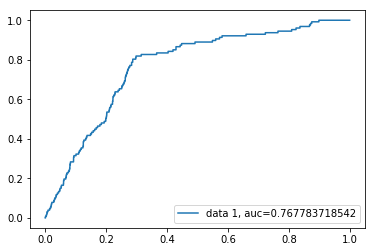

0.767783718542


In [184]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(auc)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [185]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [186]:
# Clean dat
clean_test = clean_data(mailout_test)

In [187]:
LNR_test = clean_test['LNR']
clean_test.drop('LNR', axis=1, inplace=True)

In [188]:
# Cheking number of registers with missing value
clean_test.isnull().sum().sum()

27803

In [189]:
# Checking number of object data (in case there is any, we need to remove it) 
clean_test.select_dtypes(include='object').sum().sum()

0.0

In [190]:
# Imputer
imputed_test = pd.DataFrame(imputer.fit_transform(clean_test.values), columns=clean_test.columns)

In [191]:
# feature scaling
scaled_test = pd.DataFrame(scaler.fit_transform(imputed_test.values), columns=imputed_test.columns)

In [192]:
# Model A
pred = model.predict(scaled_test)

In [193]:
submission = pd.DataFrame(LNR_test)

In [194]:
submission['RESPONSE'] = pred

In [195]:
# Save file to submit
submission.to_csv('Submission.csv', index=False)